In [113]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from scipy.io import loadmat

Given

$$\boldsymbol{r}(\boldsymbol{x})=\begin{bmatrix}x_1\\ \frac{10x_1}{x_1+0.1}+2x_2^2\end{bmatrix}$$

$$r_1 = x_1 = 0$$

If $x_1=0$ then $r_2=2x_2^2$, which can only be $0$ if $x_2=0$


Jacobian of $\boldsymbol{r}$

$$J_\boldsymbol{r}=\begin{bmatrix}1 & 0\\\frac{10}{x_1+0.1}-\frac{10x_1}{(x_1+0.1)^2}&4x_2\end{bmatrix}$$

Determinant is $0$ at $(0,0)$ as such singular

In [10]:
def linearLSQ(A, y):
    Q, R = np.linalg.qr(A, mode='reduced')
    x = np.linalg.solve(R, np.dot(Q.T, y))

    return x

In [108]:
def rJ(x: Union[list, np.ndarray]):
    r = np.array([x[0], (10*x[0]) / (x[0] + 0.1) + 2*x[1]**2])
    J = np.array([[1, 0],[1 / ((x[0] + 0.1) ** 2), 4*x[1]]])
    
    return r, J

r, J = rJ(np.array([1,1]))
r, J

(array([ 1.        , 11.09090909]),
 array([[1.        , 0.        ],
        [0.82644628, 4.        ]]))

In [109]:
def LM(func, x0, *args):
    maxit = 150 * len(x0)
    tol = 1.0e-10

    # Initial iteration
    x = np.array(x0)
    it = 0
    rx, Jx = func(x, *args)
    f = 0.5 * np.linalg.norm(rx)**2
    df = np.dot(Jx.T, rx)
    converged = (np.linalg.norm(df, np.inf) <= tol)
    nfun = 1

    # Initial lambda
    lamb = np.linalg.norm(np.dot(Jx.T, Jx))

    # Store data for plotting
    X = [x]
    F = [f]
    dF = [df]

    while not converged and it < maxit:
        it += 1
        
        # Calculate the search direction by solving a linear LSQ problem
        A = np.vstack([Jx, np.sqrt(lamb)*np.eye(len(x))])
        b = np.hstack([-rx, np.zeros_like(x)])
        #p = np.linalg.lstsq(A, b, rcond=None)[0]
        p = linearLSQ(A, b)
        
        # Update the iterate, Jacobian, residual, f, df
        x_new = x + p
        rx_new, Jx_new = func(x_new, *args)
        f_new = 0.5 * np.linalg.norm(rx_new)**2

        rho = (f - f_new) / (0.5 * np.dot(p, (lamb * p - np.dot(Jx.T, rx))))
        
        if rho > 0.75:
            lamb /= 3
        elif rho < 0.25:
            lamb *= 2
        
        # Accept or reject x_new
        if rho > 0:
            x = x_new
            rx = rx_new
            f = f_new
            Jx = Jx_new
            df = np.dot(Jx.T, rx)

        converged = (np.linalg.norm(df, np.inf) <= tol)
        nfun += 1

        # Store data for plotting
        X.append(x)
        F.append(f)
        dF.append(df)

    # Prepare return data
    if not converged:
        x = None  # Use None instead of empty for Python

    stat = {
        "converged": converged,
        "iter": it,
        "X": np.array(X),
        "F": np.array(F),
        "dF": np.array(dF),
        "nfun": nfun
    }
    
    return x, stat

x, stats = LM(rJ, np.array([3,1]))

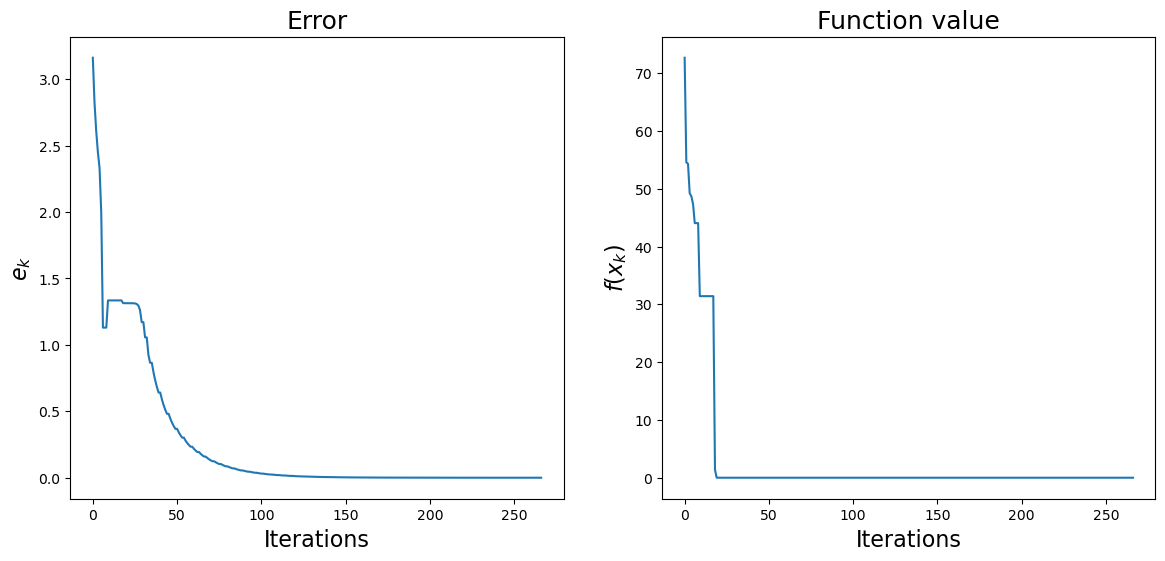

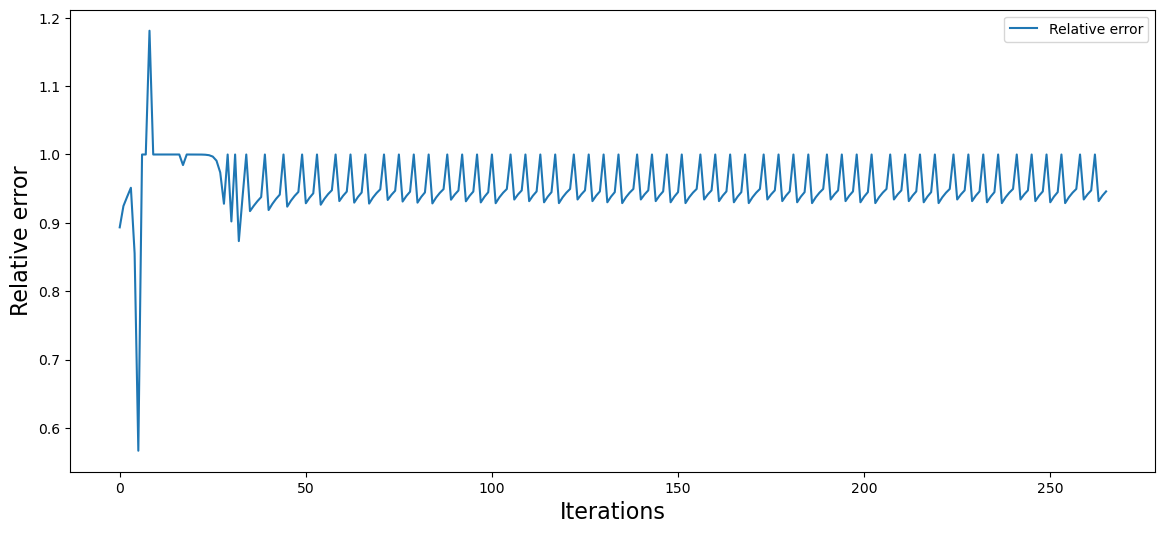

In [110]:
plt.rcParams["figure.figsize"] = 14, 6
fig, ax = plt.subplots(1, 2)

x_star = np.array([0,0])
e = np.linalg.norm(stats["X"] - x_star, axis=1)
ax[0].plot(range(stats["iter"]+1), e, label="Error")
ax[0].set_title("Error", fontsize=18)
ax[0].set_xlabel("Iterations", fontsize=16)
ax[0].set_ylabel("$e_k$", fontsize=16)

ax[1].plot(range(stats["iter"]+1), stats["F"], label="Function value")
ax[1].set_title("Function value", fontsize=18)
ax[1].set_xlabel("Iterations", fontsize=16)
ax[1].set_ylabel("$f(x_k)$", fontsize=16)
plt.show()

plt.plot(np.linalg.norm(stats["X"] - x_star, axis=1)[1:] / np.linalg.norm(stats["X"] - x_star, axis=1)[:-1], label="Relative error")
plt.legend()
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Relative error", fontsize=16)
plt.show()

In [111]:
def LM_yq(func, x0, tau, *args):
    maxit = 100 * len(x0)
    tol = 1.0e-10

    # Initial iteration
    x = np.array(x0)
    it = 0
    rx, Jx = func(x, *args)
    f = 0.5 * np.linalg.norm(rx)**2
    df = np.dot(Jx.T, rx)
    converged = (np.linalg.norm(df, np.inf) <= tol)
    nfun = 1

    # Initial lambda
    lamb = tau * np.linalg.norm(np.dot(Jx.T, Jx))
    nu = 2

    # Store data for plotting
    X = [x]
    F = [f]
    dF = [df]

    # Main loop of L-M method
    while not converged and it < maxit:
        it += 1
        
        # Calculate the search direction by solving a linear LSQ problem
        A = np.vstack([Jx, np.sqrt(lamb)*np.eye(len(x))])
        b = np.hstack([-rx, np.zeros_like(x)])
        #p = np.linalg.lstsq(A, b, rcond=None)[0]
        p = linearLSQ(A, b)
        
        # Update the iterate, Jacobian, residual, f, df
        x_new = x + p
        rx_new, Jx_new = func(x_new, *args)
        f_new = 0.5 * np.linalg.norm(rx_new)**2

        rho = (f - f_new) / (0.5 * np.dot(p.T, (lamb * p - np.dot(Jx.T, rx))))
    
        
        # Accept or reject x_new
        if rho > 0:
            x = x_new
            rx = rx_new
            f = f_new
            Jx = Jx_new
            df = np.dot(Jx.T, rx)

            lamb = lamb * max(1/3, 1 - (2 * rho - 1)**3)
            nu = 2
        else:
            lamb = lamb * nu
            nu = 2 * nu


        converged = (np.linalg.norm(df, np.inf) <= tol)
        nfun += 1

        # Store data for plotting
        X.append(x)
        F.append(f)
        dF.append(df)

    # Prepare return data
    if not converged:
        x = None  # Use None instead of empty for Python

    stat = {
        "converged": converged,
        "iter": it,
        "X": np.array(X),
        "F": np.array(F),
        "dF": np.array(dF),
        "nfun": nfun
    }
    
    return x, stat

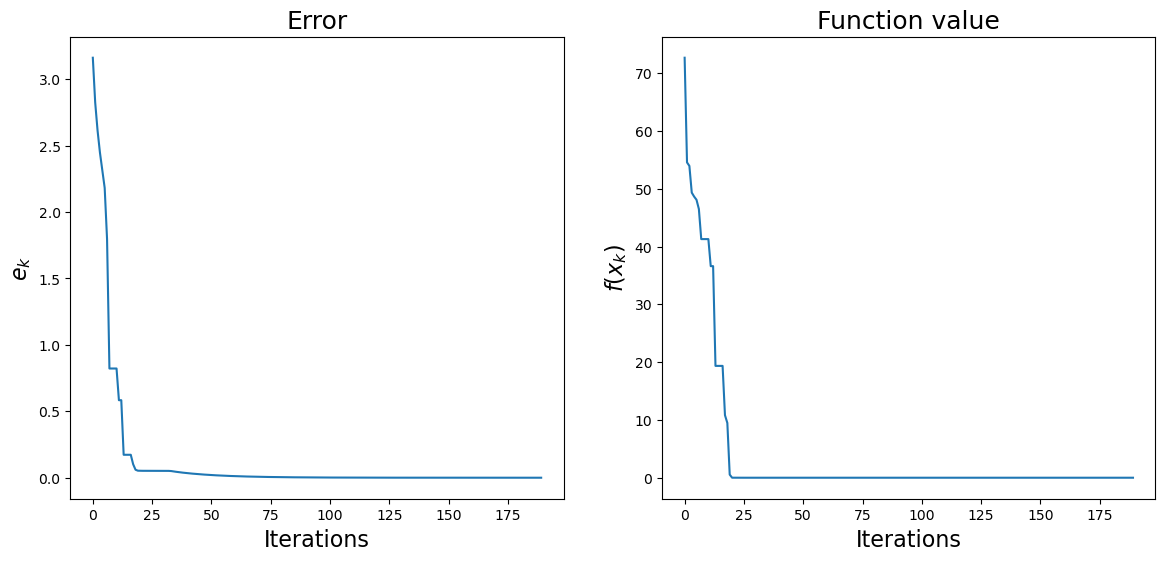

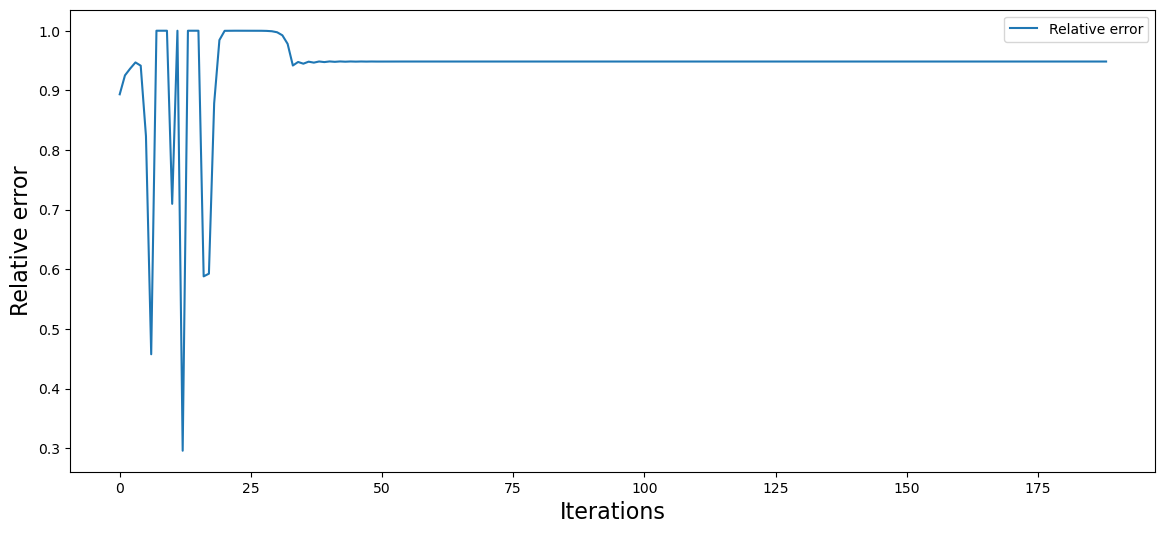

In [112]:
x, stats = LM_yq(rJ, np.array([3, 1]), tau=1)

fig, ax = plt.subplots(1, 2)

x_star = np.array([0,0])
e = np.linalg.norm(stats["X"] - x_star, axis=1)
ax[0].plot(range(stats["iter"]+1), e, label="Error")
ax[0].set_title("Error", fontsize=18)
ax[0].set_xlabel("Iterations", fontsize=16)
ax[0].set_ylabel("$e_k$", fontsize=16)

ax[1].plot(range(stats["iter"]+1), stats["F"], label="Function value")
ax[1].set_title("Function value", fontsize=18)
ax[1].set_xlabel("Iterations", fontsize=16)
ax[1].set_ylabel("$f(x_k)$", fontsize=16)
plt.show()

plt.plot(np.linalg.norm(stats["X"] - x_star, axis=1)[1:] / np.linalg.norm(stats["X"] - x_star, axis=1)[:-1], label="Relative error")
plt.legend()
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Relative error", fontsize=16)
plt.show()

## Linear least squares with weights


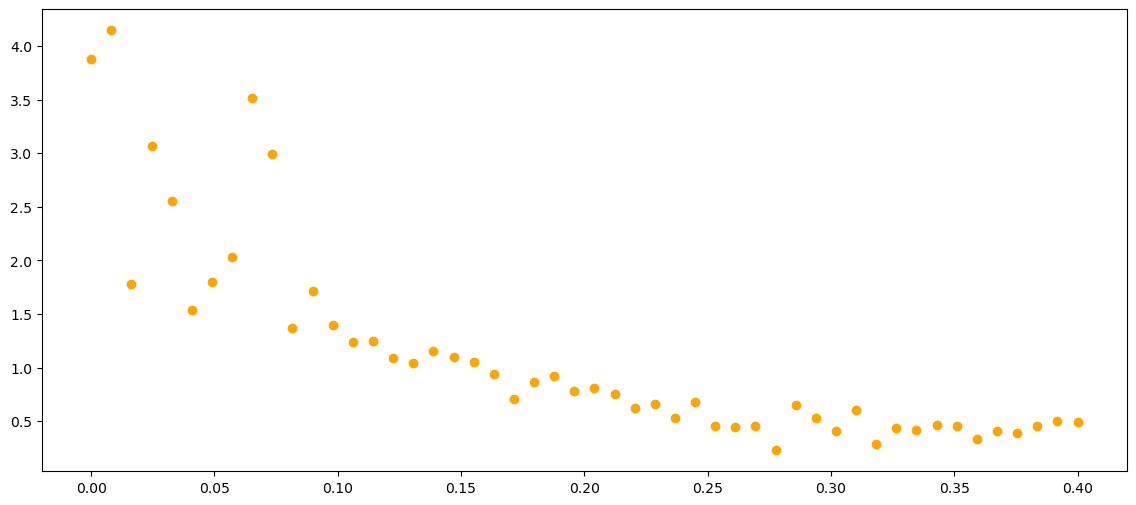

[[0.77158691]
 [2.68426325]
 [0.23270323]]
0.8173246631410934


In [164]:
data = loadmat("data_exe3_2023.mat")
t, y = data["t"], data["y"]

# plot data
plt.scatter(t, y, color="orange")
plt.show()

A = np.block([np.exp(-27*t), np.exp(-8*t), np.ones_like(t)])

x = linearLSQ(A, y)

print(x)
x_star = np.array([1.27, 2.04, 0.3])
print(np.linalg.norm(x.flatten() - x_star))

In [153]:
# weight matrix
W = np.diag([0.5 ** (-1)] * 10 + [0.1 ** (-1)] * (len(t) - 10))

In [163]:
weighted_x = linearLSQ(W@A, W@y)
print(weighted_x)
print(np.linalg.norm(weighted_x.flatten() - x_star))

[[1.19093158]
 [2.27343584]
 [0.27840347]]
0.24740759368436588


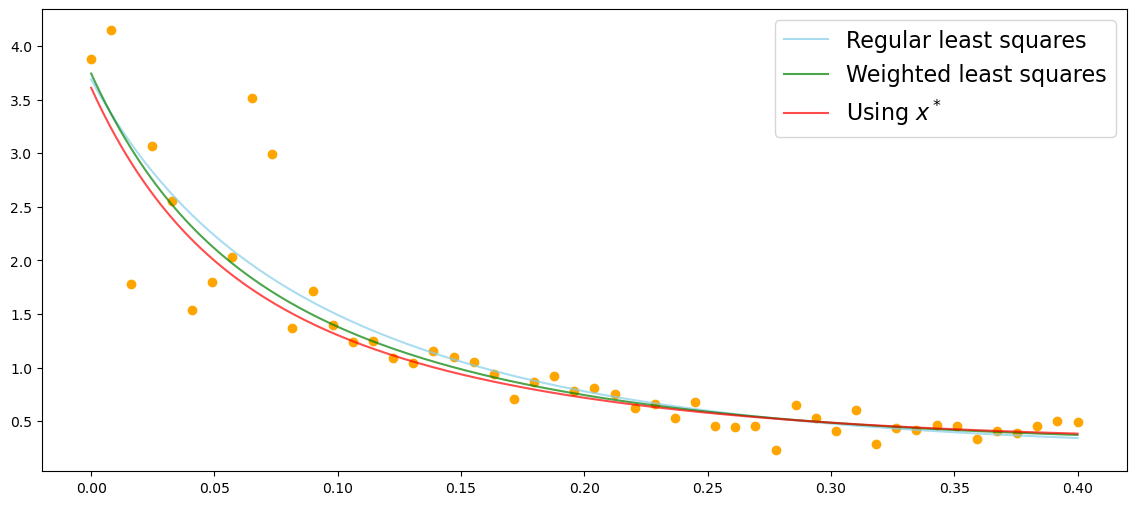

In [170]:
t_fit = np.linspace(min(t), max(t), 200)

y_fit = x[0] * np.exp(-27 * t_fit) + x[1] * np.exp(-8 * t_fit) + x[2]
weighted_y_fit = weighted_x[0] * np.exp(-27 * t_fit) + weighted_x[1] * np.exp(-8 * t_fit) + weighted_x[2]
real_fit = x_star[0] * np.exp(-27 * t_fit) + x_star[1] * np.exp(-8 * t_fit) + x_star[2]


plt.scatter(t, y, color="orange")
plt.plot(t_fit, y_fit, color="skyblue", alpha=0.7, label="Regular least squares")

plt.plot(t_fit, weighted_y_fit, color="green", alpha=0.7, label="Weighted least squares")

plt.plot(t_fit, real_fit, color="red", alpha=0.7, label="Using $x^*$")
plt.legend(fontsize=16)
plt.savefig("fit_comparison.png", bbox_inches="tight")
plt.show()